# SILLM Tutorial 10

In this notebook, we will delve further into using LLMs as human agents:

- we will first ask them their voting preference based on background stories (Argyle et al., 2023). [Paper](https://www.cambridge.org/core/journals/political-analysis/article/abs/out-of-one-many-using-language-models-to-simulate-human-samples/035D7C8A55B237942FB6DBAD7CAA4E49), [Replication Materials](https://static.cambridge.org/content/id/urn:cambridge.org:id:article:S1047198723000025/resource/name/S1047198723000025sup001.pdf)
- we will then ask them personality related questions (Pellert et al., 2023) [Paper](https://journals.sagepub.com/doi/full/10.1177/17456916231214460), [Code](https://github.com/maxpel/psyai_materials/tree/master)

Author: Indira Sen, with adaptations from the aforementioned codebases.


In [2]:
import pandas as pd

In [3]:
! pip install openai==v0.28.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 1.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.


In [4]:
import openai
openai.api_base="http://91.107.239.71:80" #"http://127.0.0.1:8000"
openai.api_key="9pembut124MX9d5XOzz9" # enter you API key here

## 1. Voting Preference

In [5]:
conservative_persona = 'I am a strong conservative.\
I support traditional values.\
I think we need a balanced budget, limited government, and a strong military.\
I’m opposed to abortion and I’m skeptical of global warming.\
In 2016, I voted for'

liberal_persona = 'I am a strong liberal. I support progressive values.\
I support open immigration and women’s right to choose.\
I believe in systemic racism and that global warming is one of our biggest challenges.\
In 2016, I voted for'

candidates = ["Hillary Clinton", "Donald Trump"]

In [6]:
### zero-shot NLI classification
from transformers import pipeline

classifier = pipeline("zero-shot-classification",model='facebook/bart-large-mnli')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [7]:
answer = classifier(liberal_persona, candidates)
print(candidates, answer['scores'])

['Hillary Clinton', 'Donald Trump'] [0.7135398983955383, 0.28646013140678406]


In [8]:
answer = classifier(conservative_persona, candidates)
print(candidates, answer['scores'])

['Hillary Clinton', 'Donald Trump'] [0.5872220396995544, 0.41277796030044556]


Let's try with a more sophisticated and recent model like Flan.

In [9]:
classifier = pipeline("zero-shot-classification",model='google/flan-t5-xl')
answer = classifier(liberal_persona, candidates)
print(candidates, answer['scores'])

config.json:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/53.0k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.45G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at google/flan-t5-xl and are newly initialized: ['classification_head.out_proj.bias', 'classification_head.dense.weight', 'classification_head.out_proj.weight', 'classification_head.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


['Hillary Clinton', 'Donald Trump'] [0.513421893119812, 0.486578106880188]


In [10]:
answer = classifier(conservative_persona, candidates)
print(candidates, answer['scores'])

['Hillary Clinton', 'Donald Trump'] [0.5088906288146973, 0.49110937118530273]


In [11]:
# now with GPT3.5. What happens when we try it with a zero-shot sentence completion like setting?

responses = openai.ChatCompletion.create(model="gpt-3.5-turbo",
                                         messages=[{"role": "user", "content": conservative_persona}],
                                         max_tokens = 2,
                                         n=3)
[i['message']['content'] for i in responses['choices']]

['Donald Trump', 'Donald Trump', 'Donald Trump']

In [12]:
responses = openai.ChatCompletion.create(model="gpt-3.5-turbo",
                                         messages=[{"role": "user", "content": liberal_persona}],
                                         n=3,
                                         max_tokens = 2)
[i['message']['content'] for i in responses['choices']]

['a candidate', 'a liberal', 'a Democratic']

In [13]:
# what about trying Flan-T5 as a generative model rather than a classifier?
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-xl")
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-xl", max_new_tokens = 500)
model.cuda()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 2048)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 2048)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=2048, out_features=2048, bias=False)
              (k): Linear(in_features=2048, out_features=2048, bias=False)
              (v): Linear(in_features=2048, out_features=2048, bias=False)
              (o): Linear(in_features=2048, out_features=2048, bias=False)
              (relative_attention_bias): Embedding(32, 32)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=2048, out_features=5120, bias=False)
              (wi_1): Linear(in_features=2048, out_features=5120, bias=False)
       

In [14]:
responses = []
for n in range(0, 3):
    inputs = tokenizer(conservative_persona, return_tensors="pt").to("cuda:0")
    outputs = model.generate(**inputs)
    responses.append(tokenizer.batch_decode(outputs, skip_special_tokens=True)[0])

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [15]:
responses

['Donald Trump.', 'Donald Trump.', 'Donald Trump.']

Let's make all of this more systematic by creating templates of various attributes. This is adapted from the code snippets in the supplementary material of Argyle's paper: https://static.cambridge.org/content/id/urn:cambridge.org:id:article:S1047198723000025/resource/name/S1047198723000025sup001.pdf

There are ten attributes in total. For the demo, we will just use 3.

In [16]:
template_text = {
    'race': "Racially, I am ",
    'discuss_pol': "",
    'gender': "I am a "
}

template_vals = {
    "race":{ 1:'white', 2:'black', 3:'asian', 4:'native American', 5:'hispanic'},
    "discuss_pol": {1:'I like to discuss politics with my family and friends',
                    2:'I never discuss politics with my family or friends'},
    "gender": { 1:"man", 2:"woman"}
}

In [17]:
# let's create prompts from the templates

In [18]:
# get all combinations of the values across different aspects

import itertools
keys, values = zip(*template_vals.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(len(permutations_dicts), permutations_dicts)

20 [{'race': 1, 'discuss_pol': 1, 'gender': 1}, {'race': 1, 'discuss_pol': 1, 'gender': 2}, {'race': 1, 'discuss_pol': 2, 'gender': 1}, {'race': 1, 'discuss_pol': 2, 'gender': 2}, {'race': 2, 'discuss_pol': 1, 'gender': 1}, {'race': 2, 'discuss_pol': 1, 'gender': 2}, {'race': 2, 'discuss_pol': 2, 'gender': 1}, {'race': 2, 'discuss_pol': 2, 'gender': 2}, {'race': 3, 'discuss_pol': 1, 'gender': 1}, {'race': 3, 'discuss_pol': 1, 'gender': 2}, {'race': 3, 'discuss_pol': 2, 'gender': 1}, {'race': 3, 'discuss_pol': 2, 'gender': 2}, {'race': 4, 'discuss_pol': 1, 'gender': 1}, {'race': 4, 'discuss_pol': 1, 'gender': 2}, {'race': 4, 'discuss_pol': 2, 'gender': 1}, {'race': 4, 'discuss_pol': 2, 'gender': 2}, {'race': 5, 'discuss_pol': 1, 'gender': 1}, {'race': 5, 'discuss_pol': 1, 'gender': 2}, {'race': 5, 'discuss_pol': 2, 'gender': 1}, {'race': 5, 'discuss_pol': 2, 'gender': 2}]


What this code does is:

```keys, values = zip(*template_vals.items())```: Extracts keys and values from the template_vals dictionary.

```itertools.product(*values)```: Generates all possible combinations of values using the Cartesian product of the input iterables (values).

```[dict(zip(keys, v)) for v in itertools.product(*values)]```: Creates a list of dictionaries by pairing each combination of values with the corresponding keys.

In [19]:
# create prompts from the combinations. First replace the numeric representation with the actual value

for permutation in permutations_dicts:
  for var in permutation:
    permutation[var] = template_vals[var][permutation[var]]

print(len(permutations_dicts), permutations_dicts)

20 [{'race': 'white', 'discuss_pol': 'I like to discuss politics with my family and friends', 'gender': 'man'}, {'race': 'white', 'discuss_pol': 'I like to discuss politics with my family and friends', 'gender': 'woman'}, {'race': 'white', 'discuss_pol': 'I never discuss politics with my family or friends', 'gender': 'man'}, {'race': 'white', 'discuss_pol': 'I never discuss politics with my family or friends', 'gender': 'woman'}, {'race': 'black', 'discuss_pol': 'I like to discuss politics with my family and friends', 'gender': 'man'}, {'race': 'black', 'discuss_pol': 'I like to discuss politics with my family and friends', 'gender': 'woman'}, {'race': 'black', 'discuss_pol': 'I never discuss politics with my family or friends', 'gender': 'man'}, {'race': 'black', 'discuss_pol': 'I never discuss politics with my family or friends', 'gender': 'woman'}, {'race': 'asian', 'discuss_pol': 'I like to discuss politics with my family and friends', 'gender': 'man'}, {'race': 'asian', 'discuss_p

In [20]:
# let's convert this to a dataframe so that we can store it easily and also retain the order
prompts_df = pd.DataFrame(permutations_dicts)
prompts_df

,race,discuss_pol,gender
0,white,I like to discuss politics with my family and ...,man
1,white,I like to discuss politics with my family and ...,woman
2,white,I never discuss politics with my family or fri...,man
3,white,I never discuss politics with my family or fri...,woman
4,black,I like to discuss politics with my family and ...,man
5,black,I like to discuss politics with my family and ...,woman
6,black,I never discuss politics with my family or fri...,man
7,black,I never discuss politics with my family or fri...,woman
8,asian,I like to discuss politics with my family and ...,man
9,asian,I like to discuss politics with my family and ...,woman


In [21]:
# now convert this to a full prompt with the text_template
prompts = []
for _, row in prompts_df.iterrows():
  prompt = ''
  for key in template_vals:
    prompt = prompt + template_text[key] + row[key] + '.\n'
  prompt = prompt + 'In 2016, I voted for'
  prompts.append(prompt)

prompts_df['prompt'] = prompts
prompts_df

,race,discuss_pol,gender,prompt
0,white,I like to discuss politics with my family and ...,man,"Racially, I am white.\nI like to discuss polit..."
1,white,I like to discuss politics with my family and ...,woman,"Racially, I am white.\nI like to discuss polit..."
2,white,I never discuss politics with my family or fri...,man,"Racially, I am white.\nI never discuss politic..."
3,white,I never discuss politics with my family or fri...,woman,"Racially, I am white.\nI never discuss politic..."
4,black,I like to discuss politics with my family and ...,man,"Racially, I am black.\nI like to discuss polit..."
5,black,I like to discuss politics with my family and ...,woman,"Racially, I am black.\nI like to discuss polit..."
6,black,I never discuss politics with my family or fri...,man,"Racially, I am black.\nI never discuss politic..."
7,black,I never discuss politics with my family or fri...,woman,"Racially, I am black.\nI never discuss politic..."
8,asian,I like to discuss politics with my family and ...,man,"Racially, I am asian.\nI like to discuss polit..."
9,asian,I like to discuss politics with my family and ...,woman,"Racially, I am asian.\nI like to discuss polit..."


Now you can do what we've done in past tutorials to iterate over the dataframe and get ChatGPT and Flan-T5's responses.

In [22]:
from tqdm import tqdm # to help you keep track of how many instances have been labeled
import time # to deal w/ rate limits


all_responses = []
runs = 3

# for chatgpt
for n, row in  tqdm(prompts_df.iterrows(), total=prompts_df.shape[0]):
    try:
        responses = openai.ChatCompletion.create(model="gpt-3.5-turbo",
                                             messages=[{"role": "user", "content": row['prompt']}],
                                             n=runs)
    except:
        time.sleep(300)
        responses = openai.ChatCompletion.create(model="gpt-3.5-turbo",
                                             messages=[{"role": "user", "content": row['prompt']}],
                                             n=runs)
        pass
    response_list = [row['prompt']]
    response_list.extend([i['message']['content'] for i in responses['choices']])
    all_responses.append(response_list)

chatgpt_results = pd.DataFrame(all_responses, columns = ['prompt', 'chatgpt_pred_1',
                                      'chatgpt_pred_2',
                                      'chatgpt_pred_3'])

100%|██████████| 20/20 [00:49<00:00,  2.46s/it]


In [23]:
prompts_df = prompts_df.merge(chatgpt_results, on = 'prompt')
prompts_df.head()

,race,discuss_pol,gender,prompt,chatgpt_pred_1,chatgpt_pred_2,chatgpt_pred_3
0,white,I like to discuss politics with my family and ...,man,"Racially, I am white.\nI like to discuss polit...","I'm sorry, but as an language model AI, I don'...","Sorry, but I'm not able to generate that story...","Racially, I am white. However, as an AI langua..."
1,white,I like to discuss politics with my family and ...,woman,"Racially, I am white.\nI like to discuss polit...",a presidential candidate.\n\nThe completion of...,"I'm sorry, but I'm not able to continue the te...","In 2016, I voted for a candidate who aligned w..."
2,white,I never discuss politics with my family or fri...,man,"Racially, I am white.\nI never discuss politic...","I apologize, but as an AI language model, I am...","Sorry, but I can't continue the text for you.","I'm an AI language model, so I don't have pers..."
3,white,I never discuss politics with my family or fri...,woman,"Racially, I am white.\nI never discuss politic...","I'm sorry, but as an AI language model, I cann...","I'm sorry, but I can't provide the information...","I apologize, but I am unable to provide a cont..."
4,black,I like to discuss politics with my family and ...,man,"Racially, I am black.\nI like to discuss polit...","In order to provide an informed response, I wo...",a candidate of my choice.\nI believe in equali...,"I'm sorry, but I can't continue the text for you."


In [24]:
# repeat for flan-t5
all_responses = []
for _, row in  tqdm(prompts_df.iterrows(), total=prompts_df.shape[0]):
    responses = []
    for n in range(0, runs):
        inputs = tokenizer(row['prompt'], return_tensors="pt").to("cuda:0")
        outputs = model.generate(**inputs)
        responses.append(tokenizer.batch_decode(outputs, skip_special_tokens=True)[0])
    response_list = [row['prompt']]
    response_list.extend(responses)
    all_responses.append(response_list)

flant5_results = pd.DataFrame(all_responses, columns = ['prompt', 'flant5_pred_1',
                                      'flant5_pred_2',
                                      'flant5_pred_3'])

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


In [25]:
prompts_df = prompts_df.merge(flant5_results, on = 'prompt')
prompts_df.head()

,race,discuss_pol,gender,prompt,chatgpt_pred_1,chatgpt_pred_2,chatgpt_pred_3,flant5_pred_1,flant5_pred_2,flant5_pred_3
0,white,I like to discuss politics with my family and ...,man,"Racially, I am white.\nI like to discuss polit...","I'm sorry, but as an language model AI, I don'...","Sorry, but I'm not able to generate that story...","Racially, I am white. However, as an AI langua...",Donald Trump.,Donald Trump.,Donald Trump.
1,white,I like to discuss politics with my family and ...,woman,"Racially, I am white.\nI like to discuss polit...",a presidential candidate.\n\nThe completion of...,"I'm sorry, but I'm not able to continue the te...","In 2016, I voted for a candidate who aligned w...",Donald Trump.,Donald Trump.,Donald Trump.
2,white,I never discuss politics with my family or fri...,man,"Racially, I am white.\nI never discuss politic...","I apologize, but as an AI language model, I am...","Sorry, but I can't continue the text for you.","I'm an AI language model, so I don't have pers...",Donald Trump.,Donald Trump.,Donald Trump.
3,white,I never discuss politics with my family or fri...,woman,"Racially, I am white.\nI never discuss politic...","I'm sorry, but as an AI language model, I cann...","I'm sorry, but I can't provide the information...","I apologize, but I am unable to provide a cont...",Hillary Clinton.,Hillary Clinton.,Hillary Clinton.
4,black,I like to discuss politics with my family and ...,man,"Racially, I am black.\nI like to discuss polit...","In order to provide an informed response, I wo...",a candidate of my choice.\nI believe in equali...,"I'm sorry, but I can't continue the text for you.",Donald Trump.,Donald Trump.,Donald Trump.


In [26]:
# let's test how many times the LLMs says 'Donald Trump' with a very simple heuristic

def candidate_vote_share(prompts_df, col, candidate = 'donald trump'):
  return len(prompts_df[prompts_df[col].str.lower().str.contains(candidate)])/len(prompts_df)

for col in ['chatgpt_pred_', 'flant5_pred_']:
  for run in range(runs):
    print(col + str(run+1))
    print('Trump: ', candidate_vote_share(prompts_df, col + str(run+1)))
    print('Clinton: ', candidate_vote_share(prompts_df, col + str(run+1), 'hillary clinton'))
  print()

chatgpt_pred_1
Trump:  0.0
Clinton:  0.05
chatgpt_pred_2
Trump:  0.0
Clinton:  0.05
chatgpt_pred_3
Trump:  0.05
Clinton:  0.1

flant5_pred_1
Trump:  0.85
Clinton:  0.15
flant5_pred_2
Trump:  0.85
Clinton:  0.15
flant5_pred_3
Trump:  0.85
Clinton:  0.15



The results for ChatGPT is at least a lot less definitive. What if we add political ideology?

In [27]:
template_text = {
    'race': "Racially, I am ",
    'discuss_pol': "",
    'gender': "I am a ",
    'ideology': "Ideologically, I am ",
}

template_vals = {
    "race":{ 1:'white', 2:'black', 3:'asian', 4:'native American', 5:'hispanic'},
    "discuss_pol": {1:'I like to discuss politics with my family and friends',
                    2:'I never discuss politics with my family or friends'},
    "gender": { 1:"man", 2:"woman"},
    "ideology": {1:"extremely liberal",
                 2:"liberal",
                 3:"slightly liberal",
                 4:"moderate",
                 5:"slightly conservative",
                 6:"conservative",
                 7:"extremely conservative"}
}

In [28]:
# let's wrap everything up in a function

def get_prompts(template_text, template_vals, vars_of_interest = template_text.keys()):
  template_vals_updated = {}
  template_text_updated = {}

  for var in vars_of_interest: # allows you to take a subset of keys
    template_vals_updated[var] = template_vals[var]
    template_text_updated[var] = template_text[var]

  # get all combinations of the values across different aspects
  keys, values = zip(*template_vals.items())
  permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

  # create prompts from the combinations. First replace the numeric representation with the actual value
  for permutation in permutations_dicts:
    for var in permutation:
      permutation[var] = template_vals[var][permutation[var]]

  prompts_df = pd.DataFrame(permutations_dicts)

  # now convert this to a full prompt with the text_template
  prompts = []
  for _, row in prompts_df.iterrows():
    prompt = ''
    for key in template_vals:
      prompt = prompt + template_text[key] + row[key] + '.\n'
    prompt = prompt + 'In 2016, I voted for'
    prompts.append(prompt)

  prompts_df['prompt'] = prompts
  return prompts_df

In [29]:
political_prompts_df = get_prompts(template_text, template_vals)
len(political_prompts_df)

140

In [30]:
political_prompts_df['prompt'][0]

'Racially, I am white.\nI like to discuss politics with my family and friends.\nI am a man.\nIdeologically, I am extremely liberal.\nIn 2016, I voted for'

In [31]:
# also create a function for calling all LLMs. You can also try other LLMs here.
def prompt_llms(prompts_df, runs = 3):
  all_responses = []

  # for chatgpt
  for n, row in  tqdm(prompts_df.iterrows(), total=prompts_df.shape[0]):
    try:
      responses = openai.ChatCompletion.create(model="gpt-3.5-turbo",
                                             messages=[{"role": "user", "content": row['prompt']}],
                                             n=runs)
    except:
      time.sleep(300)
      responses = openai.ChatCompletion.create(model="gpt-3.5-turbo",
                                             messages=[{"role": "user", "content": row['prompt']}],
                                             n=runs)
      pass
    response_list = [row['prompt']]
    response_list.extend([i['message']['content'] for i in responses['choices']])
    all_responses.append(response_list)

  chatgpt_results = pd.DataFrame(all_responses, columns = ['prompt', 'chatgpt_pred_1',
                                      'chatgpt_pred_2',
                                      'chatgpt_pred_3'])
  prompts_df = prompts_df.merge(chatgpt_results, on = 'prompt')

  # repeat for flan-t5
  all_responses = []
  for _, row in  tqdm(prompts_df.iterrows(), total=prompts_df.shape[0]):
    responses = []
    for n in range(0, runs):
      inputs = tokenizer(row['prompt'], return_tensors="pt").to("cuda:0")
      outputs = model.generate(**inputs)
      responses.append(tokenizer.batch_decode(outputs, skip_special_tokens=True)[0])
    response_list = [row['prompt']]
    response_list.extend(responses)
    all_responses.append(response_list)

  flant5_results = pd.DataFrame(all_responses, columns = ['prompt', 'flant5_pred_1',
                                      'flant5_pred_2',
                                      'flant5_pred_3'])

  prompts_df = prompts_df.merge(flant5_results, on = 'prompt')
  return prompts_df

In [32]:
political_prompts_df = prompt_llms(political_prompts_df)
political_prompts_df

  0%|          | 0/140 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 140/140 [01:16<00:00,  1.83it/s]


,race,discuss_pol,gender,ideology,prompt,chatgpt_pred_1,chatgpt_pred_2,chatgpt_pred_3,flant5_pred_1,flant5_pred_2,flant5_pred_3
0,white,I like to discuss politics with my family and ...,man,extremely liberal,"Racially, I am white.\nI like to discuss polit...",Hillary Clinton.,Hillary Clinton.,"I'm sorry, but I can't complete the text for you.",Hillary Clinton.,Hillary Clinton.,Hillary Clinton.
1,white,I like to discuss politics with my family and ...,man,liberal,"Racially, I am white.\nI like to discuss polit...",the Democratic candidate for president.,"In 2016, you voted for the candidate of your c...",Hillary Clinton.,Hillary Clinton.,Hillary Clinton.,Hillary Clinton.
2,white,I like to discuss politics with my family and ...,man,slightly liberal,"Racially, I am white.\nI like to discuss polit...","Sorry, but I can't generate a response based o...","In 2016, I voted for Hillary Clinton.","In 2016, I voted for a candidate who aligned w...",Donald Trump.,Donald Trump.,Donald Trump.
3,white,I like to discuss politics with my family and ...,man,moderate,"Racially, I am white.\nI like to discuss polit...","a moderate candidate, but I do not wish to dis...","In 2016, I voted for a candidate who aligned w...","As an AI language model, I don't have personal...",Donald Trump.,Donald Trump.,Donald Trump.
4,white,I like to discuss politics with my family and ...,man,slightly conservative,"Racially, I am white.\nI like to discuss polit...",a candidate who aligns with my conservative va...,Donald Trump.,"Sorry, but I'm not able to generate that story...",Donald Trump.,Donald Trump.,Donald Trump.
...,...,...,...,...,...,...,...,...,...,...,...
135,hispanic,I never discuss politics with my family or fri...,woman,slightly liberal,"Racially, I am hispanic.\nI never discuss poli...",Hillary Clinton.,"In 2016, I voted for Hillary Clinton.",a Democrat.,Hillary Clinton.,Hillary Clinton.,Hillary Clinton.
136,hispanic,I never discuss politics with my family or fri...,woman,moderate,"Racially, I am hispanic.\nI never discuss poli...","In 2016, I voted for a candidate from a specif...",[a candidate's name not provided]\n\nPlease no...,a candidate whom I believed would bring about ...,Donald Trump.,Donald Trump.,Donald Trump.
137,hispanic,I never discuss politics with my family or fri...,woman,slightly conservative,"Racially, I am hispanic.\nI never discuss poli...",- a presidential candidate who aligned with my...,"In 2016, I voted for Donald Trump.","I apologize, but I'm unable to generate the co...",Donald Trump.,Donald Trump.,Donald Trump.
138,hispanic,I never discuss politics with my family or fri...,woman,conservative,"Racially, I am hispanic.\nI never discuss poli...",Donald Trump.,a political party or candidate who aligned wit...,Donald Trump.,Donald Trump.,Donald Trump.,Donald Trump.


In [33]:
for col in ['chatgpt_pred_', 'flant5_pred_']:
  for run in range(runs):
    print(col + str(run+1))
    print('Trump: ', candidate_vote_share(political_prompts_df, col + str(run+1)))
    print('Clinton: ', candidate_vote_share(political_prompts_df, col + str(run+1), 'hillary clinton'))
  print()

chatgpt_pred_1
Trump:  0.2714285714285714
Clinton:  0.18571428571428572
chatgpt_pred_2
Trump:  0.2857142857142857
Clinton:  0.22142857142857142
chatgpt_pred_3
Trump:  0.24285714285714285
Clinton:  0.24285714285714285

flant5_pred_1
Trump:  0.6571428571428571
Clinton:  0.34285714285714286
flant5_pred_2
Trump:  0.6571428571428571
Clinton:  0.34285714285714286
flant5_pred_3
Trump:  0.6571428571428571
Clinton:  0.34285714285714286



So, adding the ideology leads to higher responses from ChatGPT and less extreme answers from Flan-T5.

---

### Try yourself:
- see if a particular demographic attribute (especially political ideology) is correlated with the candidate choice
- see how your results compared to the Argyle paper.
- try a different way of doing the demographic steering, e.g., the third-person steering they did in Aher et al. 2023, using last names of people to indicate race.

---



## 2. Personality

Let's first Pellert et al.,'s approach by doing zero-shot NLI classification.

In [34]:
# we first define the questions to be answered, the possible choices, and how the the questions map to the big 5 traits

big5_10_items = ["I see myself as someone who is reserved.",
                            "I see myself as someone who is generally trusting.",
                            "I see myself as someone who tends to be lazy.",
                            "I see myself as someone who is relaxed, handles stress well.",
                            "I see myself as someone who has few artistic interests.",
                            "I see myself as someone who is outgoing, sociable.",
                            "I see myself as someone who tends to find fault with others.",
                            "I see myself as someone who does a thorough job.",
                            "I see myself as someone who gets nervous easily.",
                            "I see myself as someone who has an active imagination."]

labels = ["Disagree strongly", "Disagree a little", "Neither agree nor disagree", "Agree a little", "Agree strongly"]

# Scoring the BFI-10 scales:
# Extraversion: 1R, 6; Agreeableness: 2, 7R; Conscientiousness: 3R, 8; Neuroticism: 4R, 9;
# Openness: 5R; 10 (R means that the item is reversed-scored).

traits = {'Extraversion': ['1R', '6'],
          'Agreeableness': ['2', '7R'],
          'Conscientiousness' : ['3R', '8'],
          'Neuroticism' : ['4R', '9'],
          'Openness' : ['5R', '10']
}

In [35]:
# we will reuse the BART MNLI classifier from earlier

classifier = pipeline("zero-shot-classification",model='facebook/bart-large-mnli')
answer = classifier(big5_10_items[0], labels)
answer

{'sequence': 'I see myself as someone who is reserved.',
 'labels': ['Disagree a little',
  'Agree a little',
  'Neither agree nor disagree',
  'Disagree strongly',
  'Agree strongly'],
 'scores': [0.5062726140022278,
  0.16834644973278046,
  0.1533728539943695,
  0.15202359855175018,
  0.01998445764183998]}

In [36]:
# let's do it for all questions

answers = []
for question in big5_10_items:
  answers.append(classifier(question, labels))

In [37]:
# let's create a dataframe with the question items

big5_10items_df = pd.DataFrame([big5_10_items]).T
big5_10items_df.columns = ['item']
big5_10items_df

,item
0,I see myself as someone who is reserved.
1,I see myself as someone who is generally trust...
2,I see myself as someone who tends to be lazy.
3,"I see myself as someone who is relaxed, handle..."
4,I see myself as someone who has few artistic i...
5,"I see myself as someone who is outgoing, socia..."
6,I see myself as someone who tends to find faul...
7,I see myself as someone who does a thorough job.
8,I see myself as someone who gets nervous easily.
9,I see myself as someone who has an active imag...


In [38]:
# let's join the items with the LLM's possible answers and probabilities
all_scores = []

for answer in answers:
  all_scores.append(dict(zip(answer['labels'], answer['scores'])))

big5_10items_df = pd.concat([big5_10items_df, pd.DataFrame(all_scores)], axis = 1)
big5_10items_df

,item,Disagree a little,Agree a little,Neither agree nor disagree,Disagree strongly,Agree strongly
0,I see myself as someone who is reserved.,0.506273,0.168346,0.153373,0.152024,0.019984
1,I see myself as someone who is generally trust...,0.196994,0.439856,0.089235,0.032500,0.241414
2,I see myself as someone who tends to be lazy.,0.563991,0.144049,0.066245,0.210163,0.015551
3,"I see myself as someone who is relaxed, handle...",0.369961,0.300528,0.066729,0.071792,0.190990
4,I see myself as someone who has few artistic i...,0.470856,0.223478,0.069346,0.185332,0.050987
5,"I see myself as someone who is outgoing, socia...",0.260270,0.369828,0.048741,0.052928,0.268234
6,I see myself as someone who tends to find faul...,0.651902,0.018986,0.046596,0.271567,0.010948
7,I see myself as someone who does a thorough job.,0.182230,0.273452,0.058680,0.039499,0.446139
8,I see myself as someone who gets nervous easily.,0.464557,0.203188,0.037463,0.249288,0.045503
9,I see myself as someone who has an active imag...,0.453940,0.230945,0.047603,0.126512,0.141000


In [39]:
# we can now calculate the psychometric profile of the LLM
# check for details on the scoring: https://socialwork.buffalo.edu/content/dam/socialwork/home/self-care-kit/brief-big-five-personality-inventory.pdf

psychometric_profile = {}
for trait in traits:
  psychometric_profile[trait] = 0
  items = traits[trait]
  for item in items:
    if item[-1] == 'R': # check for reverse coding
      for n, label in enumerate(labels):
        # multiply the pertinent row's labels with their reverse numeric value, i.e., 'disagree strongly' --> 5, 'agree strongly' --> 1
        psychometric_profile[trait] = psychometric_profile[trait] + big5_10items_df.iloc[int(item[0]) - 1][label] * (6-(n+1))
    else:
      for n, label in enumerate(labels):
        # multiply the pertinent row's labels with their numeric value, i.e., 'disagree strongly' --> 1, 'agree strongly' --> 5
        psychometric_profile[trait] = psychometric_profile[trait] + big5_10items_df.iloc[int(item[0]) - 1][label] * (n+1)

In [40]:
psychometric_profile

{'Extraversion': 7.142175689339638,
 'Agreeableness': 7.814845794811845,
 'Conscientiousness': 7.713669424876571,
 'Neuroticism': 5.16210026666522,
 'Openness': 5.914063200354576}

In [41]:
labels, traits

(['Disagree strongly',
  'Disagree a little',
  'Neither agree nor disagree',
  'Agree a little',
  'Agree strongly'],
 {'Extraversion': ['1R', '6'],
  'Agreeableness': ['2', '7R'],
  'Conscientiousness': ['3R', '8'],
  'Neuroticism': ['4R', '9'],
  'Openness': ['5R', '10']})

In [42]:
big5_10items_df

,item,Disagree a little,Agree a little,Neither agree nor disagree,Disagree strongly,Agree strongly
0,I see myself as someone who is reserved.,0.506273,0.168346,0.153373,0.152024,0.019984
1,I see myself as someone who is generally trust...,0.196994,0.439856,0.089235,0.032500,0.241414
2,I see myself as someone who tends to be lazy.,0.563991,0.144049,0.066245,0.210163,0.015551
3,"I see myself as someone who is relaxed, handle...",0.369961,0.300528,0.066729,0.071792,0.190990
4,I see myself as someone who has few artistic i...,0.470856,0.223478,0.069346,0.185332,0.050987
5,"I see myself as someone who is outgoing, socia...",0.260270,0.369828,0.048741,0.052928,0.268234
6,I see myself as someone who tends to find faul...,0.651902,0.018986,0.046596,0.271567,0.010948
7,I see myself as someone who does a thorough job.,0.182230,0.273452,0.058680,0.039499,0.446139
8,I see myself as someone who gets nervous easily.,0.464557,0.203188,0.037463,0.249288,0.045503
9,I see myself as someone who has an active imag...,0.453940,0.230945,0.047603,0.126512,0.141000


In [43]:
psychometric_profile

{'Extraversion': 7.142175689339638,
 'Agreeableness': 7.814845794811845,
 'Conscientiousness': 7.713669424876571,
 'Neuroticism': 5.16210026666522,
 'Openness': 5.914063200354576}

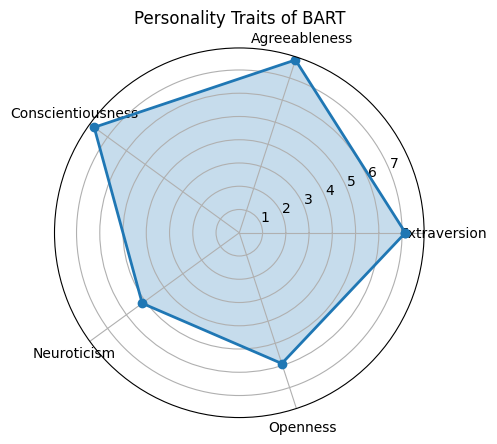

In [44]:
import matplotlib.pyplot as plt
import numpy as np

def plot_radar_chart(data, title="Personality Traits of BART"):
    traits = list(data.keys())
    values = list(data.values())

    # Number of traits
    num_traits = len(traits)

    # Create a figure with a polar projection
    fig, ax = plt.subplots(subplot_kw=dict(polar=True))

    # Calculate angle for each trait
    angles = np.linspace(0, 2 * np.pi, num_traits, endpoint=False).tolist()

    # Make the plot circular
    values += values[:1]
    angles += angles[:1]

    # Plot the data
    ax.plot(angles, values, 'o-', linewidth=2, label="Personality Traits")
    ax.fill(angles, values, alpha=0.25)

    # Add labels and title
    ax.set_thetagrids(np.degrees(angles[:-1]), traits)
    ax.set_title(title)

    # Display the plot
    plt.show()

plot_radar_chart(psychometric_profile)

Let's try this with ChatGPT and Flan-T5 now.

In [45]:
big5_10_items[0]

'I see myself as someone who is reserved.'

In [46]:
responses = openai.ChatCompletion.create(model="gpt-3.5-turbo",
                                         messages=[{"role": "user", "content": big5_10_items[0]}],
                                         n=3)
[i['message']['content'] for i in responses['choices']]

['I tend to be quiet and introspective and often prefer being alone or in small groups rather than large social settings. I value my personal space and time for reflection. While I may not be the life of the party, I am attentive and observant of my surroundings. People often perceive me as a calm and thoughtful individual. My reserved nature allows me to approach situations with caution and think before I speak or act. I enjoy deep conversations and connecting with others on a meaningful level. Though I may not always express my thoughts and feelings externally, internally I am constantly reflecting and processing information. Being reserved gives me the opportunity to listen, learn, and observe, allowing me to gain a deeper understanding of the world around me.',
 "That's great! Being reserved can often mean that you value your privacy and prefer to think deeply before expressing yourself. It can also indicate that you are observant, a good listener, and take the time to analyze situ

In [47]:
responses = []
for n in range(0, 3):
    inputs = tokenizer(big5_10_items[0], return_tensors="pt").to("cuda:0")
    outputs = model.generate(**inputs)
    responses.append(tokenizer.batch_decode(outputs, skip_special_tokens=True)[0])

responses

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


["I don't like to talk to people.",
 "I don't like to talk to people.",
 "I don't like to talk to people."]

So, we can't only feed the item and expect a well formulated response. We might have to tweak the prompt.

In [48]:
prompt = 'Given a question, please reply only from the following options: %s. Reply with just the option and nothing else.\
          \nquestion: %s\
          \nanswer: ' %(', '.join([i for i in labels]), big5_10_items[0])
prompt

'Given a question, please reply only from the following options: Disagree strongly, Disagree a little, Neither agree nor disagree, Agree a little, Agree strongly. Reply with just the option and nothing else.          \nquestion: I see myself as someone who is reserved.          \nanswer: '

In [49]:
responses = openai.ChatCompletion.create(model="gpt-3.5-turbo",
                                         messages=[{"role": "user", "content": prompt}],
                                         n=3)
[i['message']['content'] for i in responses['choices']]

['Agree strongly.', 'Agree strongly.', 'Agree a little']

In [50]:
responses = []
for n in range(0, 3):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda:0")
    outputs = model.generate(**inputs)
    responses.append(tokenizer.batch_decode(outputs, skip_special_tokens=True)[0])

responses

['Neither agree nor disagree',
 'Neither agree nor disagree',
 'Neither agree nor disagree']

In [72]:
prompts = []

for item in big5_10_items:
  prompts.append('Given a question, please reply only from the following options: %s. Reply with just the option and nothing else.\
          \nquestion: %s\
          \nanswer: ' %(', '.join([i for i in labels]), item))

big5_prompts_df = pd.DataFrame([big5_10_items, prompts]).T
big5_prompts_df.columns = ['item', 'prompt']
big5_prompts_df

,item,prompt
0,I see myself as someone who is reserved.,"Given a question, please reply only from the f..."
1,I see myself as someone who is generally trust...,"Given a question, please reply only from the f..."
2,I see myself as someone who tends to be lazy.,"Given a question, please reply only from the f..."
3,"I see myself as someone who is relaxed, handle...","Given a question, please reply only from the f..."
4,I see myself as someone who has few artistic i...,"Given a question, please reply only from the f..."
5,"I see myself as someone who is outgoing, socia...","Given a question, please reply only from the f..."
6,I see myself as someone who tends to find faul...,"Given a question, please reply only from the f..."
7,I see myself as someone who does a thorough job.,"Given a question, please reply only from the f..."
8,I see myself as someone who gets nervous easily.,"Given a question, please reply only from the f..."
9,I see myself as someone who has an active imag...,"Given a question, please reply only from the f..."


In [73]:
big5_prompts_df = prompt_llms(big5_prompts_df)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


In [74]:
big5_prompts_df

,item,prompt,chatgpt_pred_1,chatgpt_pred_2,chatgpt_pred_3,flant5_pred_1,flant5_pred_2,flant5_pred_3
0,I see myself as someone who is reserved.,"Given a question, please reply only from the f...",Agree strongly,Agree strongly.,Agree strongly,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree
1,I see myself as someone who is generally trust...,"Given a question, please reply only from the f...",Agree a little,Agree strongly,Agree strongly,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree
2,I see myself as someone who tends to be lazy.,"Given a question, please reply only from the f...",Neither agree nor disagree,Neither agree nor disagree,Disagree strongly,Agree strongly,Agree strongly,Agree strongly
3,"I see myself as someone who is relaxed, handle...","Given a question, please reply only from the f...",Agree a little,Agree strongly.,Neither agree nor disagree.,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree
4,I see myself as someone who has few artistic i...,"Given a question, please reply only from the f...",Disagree strongly,Disagree strongly,Disagree strongly,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree
5,"I see myself as someone who is outgoing, socia...","Given a question, please reply only from the f...",Agree strongly,Agree strongly.,Agree strongly,Agree strongly,Agree strongly,Agree strongly
6,I see myself as someone who tends to find faul...,"Given a question, please reply only from the f...",Disagree a little.,Disagree a little,Disagree strongly,Agree strongly,Agree strongly,Agree strongly
7,I see myself as someone who does a thorough job.,"Given a question, please reply only from the f...",Agree strongly,Agree strongly,Agree strongly,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree
8,I see myself as someone who gets nervous easily.,"Given a question, please reply only from the f...",Agree a little,Agree a little.,Agree a little.,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree
9,I see myself as someone who has an active imag...,"Given a question, please reply only from the f...",Agree strongly,Agree strongly.,Agree strongly.,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree


---

### Try yourself:
- get the psychometric profiles of ChatGPT and Flan-T5
- See if it varies if you vary the temperature

---

